In [5]:
#### Dev Only Cell ####
# Run this cell to export production code to .py file in the parent folder
# dev_only cells will not be written to .py

!jupyter nbconvert --to script OllaGen1.ipynb --output-dir='../OllaGen-1' --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"dev_only"}'

[NbConvertApp] Converting notebook OllaGen1.ipynb to script
[NbConvertApp] Writing 16956 bytes to ..\OllaGen1.py


In [ ]:
# IMPORTS

## Import Python Libraries
import os
import doctest
import datetime
import random

import itertools
import copy
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import csv
import json

## Import local modules
#- n/a

params_path="params.json"
params={}
# Read the parameters from the JSON file
try:
    with open(params_path, 'r') as file:
        params = json.load(file)   
except FileNotFoundError:
    print(f"The file {params_path} was not found.")
except json.JSONDecodeError:
    print(f"Error decoding JSON from the file {params_path}.")
# Initialize variables
node_path = params['node_path']
edge_path = params['edge_path']
dict_path = params["dict_path"]
llm_framework = params["llm_framework"]
QA_TF_questions = params["QA_TF_questions"]
QA_TF_coglength = params["QA_TF_coglength"]
QA_TF_outpath = params["QA_TF_outpath"]
QA_WCP_questions = params["QA_WCP_questions"]
QA_WCP_coglength = params["QA_WCP_coglength"]
QA_WCP_outpath = params["QA_WCP_outpath"]
QA_WHO_questions = params["QA_WHO_questions"]
QA_WHO_outpath = params["QA_WHO_outpath"] 

if llm_framework=="openai":
    from openai import OpenAI
    client = OpenAI(
        # This is the default and can be omitted
        api_key=os.environ.get("OPENAI_API_KEY"),
    )
if llm_framework=="llama_index":
    from llama_index.llms import LocalTensorRTLLM
    def completion_to_prompt(completion: str) -> str:
        """
        Given a completion, return the prompt using llama2 format.
        """
        return f"<s> [INST] {completion} [/INST] "
    llm = LocalTensorRTLLM(
    model_path="./model",
    engine_name="llama_float16_tp1_rank0.engine",
    tokenizer_dir="meta-llama/Llama-2-13b-chat",
    completion_to_prompt=completion_to_prompt)

In [2]:
# FUNCTIONS

def graph_load (nodes, edges):
    """
    Load a graph from a csv list of nodes and edges. Requires networkx.
    
    Parameters:
    nodes : csv file of nodes with header of "Nodes"
    
    Returns:
    the_graph : a networkx graph object
    """
    the_graph = nx.Graph()
    try:
        # sanitize and check paths
            # to be developed
        
        # load nodes
        node_list = pd.read_csv(nodes)
        # load edges
        edge_list = pd.read_csv(edges)

        # Create graph
        for i, row in edge_list.iterrows(): # Add edges and edge attributes
            the_graph.add_edge(row[0], row[1], attr_dict=row.iloc[2:].to_dict())
    except Exception as e:
        print("Error happens: "+e)
        # log errors as needed
    return the_graph

def graph_plot (a_graph,a_title):
    """
    Take a networkx graph object, a title and plot them out.
    
    Parameters:
    a_graph : a networkx graph object
    a_title : the title for the plot
    
    Returns:
    result : a boolean value
    """
    result = ""
    try:
        plt.figure(figsize=(16, 12))
        node_pos=nx.shell_layout(a_graph, scale=4)
        nx.draw(a_graph,pos=node_pos, node_size=30, node_color='green', edge_color='grey')
        title_pos=node_pos
        for item in title_pos:
            title_pos[item][1] += 0.2
        nx.draw_networkx_labels(a_graph, pos = title_pos, font_size = 14)
        plt.title(a_title, size=25)
        plt.show()
        result=True
    except Exception as e:
        print("Error happens: "+e)
        # log errors as needed
        result=False
    return result

def csv_2_nlevel_dict (csv_file):
    """
    Convert a csv file to an n-level dictionary.
    
    Parameters:
    csv_file : the path to a csv file
    
    Returns:
    result_dict : an n-level dictionary
    """
    result_dict = {}
    try:
        with open(csv_file, newline='') as csvfile:
            reader = csv.reader(csvfile)
            next(reader, None)  # Skip header if present
            for row in reader:
                *keys, value = row  # Unpack all but the last item as keys, and the last item as value
                current_level = result_dict
                for key in keys[:-1]:  # Iterate over keys except for the last one
                    if key not in current_level:
                        current_level[key] = {}
                    current_level = current_level[key]
                # Set the value for the last key
                last_key = keys[-1]
                current_level[last_key] = value  # This will overwrite existing values for duplicate paths
        csvfile.close()
    except Exception as e:
        print("Error happens: "+e)
        # log errors as needed
        result_dict=False
    return result_dict

def print_dict(d, n, indent=0, counter=None):
    """
    Prints the first n items of a multi-level dictionary.
    
    :param d: The dictionary to print from.
    :param n: The number of items to print.
    :param indent: Current indentation level for pretty printing.
    :param counter: A mutable counter to track the number of items printed.
    """
    if counter is None:
        counter = [0]  # Initialize the counter if it's not provided

    if counter[0] >= n:
        return  # Stop if the desired number of items have already been printed
    
    for key, value in d.items():
        if counter[0] >= n:
            break  # Stop if the desired number of items have already been printed
        
        # Print the current item
        print('  ' * indent + str(key) + ':', end=' ')
        if isinstance(value, type(dict)):
            print()  # Print a newline before going deeper
            print_dict(value, n, indent + 1, counter)
        else:
            print(value)
            counter[0] += 1  # Increment the counter after printing a non-dictionary item

def get_random_item(two_level_dict, key1, key2):
    """
    Returns a random item from the list found at two_level_dict[key1][key2].

    :param two_level_dict: A dictionary containing dictionaries as values.
    :param key1: The key to access the first level dictionary.
    :param key2: The key to access the list in the second level dictionary.

    :return: A random item from the specified list, or None if the keys are not found.
    """
    try:
        # Access the nested dictionary and then the list
        value_list = list(two_level_dict[key1][key2])
        # Return a random item from the list
        return random.choice(value_list)
    except KeyError:
        # Return None if the specified keys are not found
        print("KeyError: The provided keys do not match the dictionary structure.")
        return None
    except IndexError:
        # Handle empty list
        print("IndexError: The list is empty.")
        return None

def get_response(prompt, engine="gpt-3.5-turbo"):
    """
    Takes a prompt and returns a response from local LLM or ChatGPT using the specified engine.

    Parameters:
    prompt (str): The input prompt
    engine (str): The engine to use for generating the response.

    Returns:
    str: The response.
    """
    try:
        if llm_framework=="openai":
            response = client.chat.completions.create(
                messages=[
                    {
                        "role": "user",
                        "content": prompt,
                    }
                ],
                model=engine,
            )
            return response.choices[0].message.content
        if llm_framework=="llama_index":
            response = llm.complete(prompt)
            return str(response)
    except Exception as e:
        return f"An error occurred: {str(e)}"

def replace_n_random_items(main_list, second_list, n):
    """
    Replace n random elements of main_list with n random elements from second_list.
    
    Parameters:
    main_list (list): The original list to modify.
    second_list (list): The list from which to take replacement elements.
    n (int): The number of elements to replace.
    
    Returns:
    list: A new list with n random elements of main_list replaced by n random elements of second_list.
    """
    result = main_list.copy()
    candidates = second_list.copy()
    
    if n<len(result) and n<len(candidates): # Ensure n does not exceed the length of either list
        for _ in range(n):
            random_pos=random.randint(0, len(result) - 1)
            result.pop(random_pos)
        for _ in range(n):
            random_pos=random.randint(0, len(candidates) - 1)
            result.append(candidates.pop(random_pos))
    
    return result
    
def ollagen1_TF(knowledge_graph,a_dict,profile_num,profile_length):
    """
    Generate True/False questions with reference answers.
    
    Parameters:
    knowledge_graph : a networkx knowledge graph that was rigorously verified
    a_dict : a dictionary of prompt templates
    profile_num : the number of questions (aka profiles) to be generated
    profile_length : the length of the profile's cognitive behavioral path
    
    Returns:
    QA_TF_df : a dataframe of generated content based on the provided params
    """
    print("Working on "+QA_TF_outpath)
    profiles=[]
    question=""
    answer=""
    QA_TF_df = pd.DataFrame(columns=['ID','Context','Question','Answer']) 

    random_paths = nx.generate_random_paths(knowledge_graph, sample_size=profile_num, path_length=(profile_length-1))
    for path in random_paths:
        if len(path) == len(set(path)):  # Check if the sublist has duplicates by comparing its length to the length of its set
            profiles.append(path)  # If no duplicates, append to the new list of cognitive behavioral profile

    random_flags = random.choices(["com","noncom"],k=(profile_num))

    counter=0
    for profile in profiles:
        story=""
        profile_type = random_flags.pop(0)
        subject_name = get_response("Give a random human name in the format of 'Firstname Lastname'")
        for item in profile:
            prompt=str(get_random_item(a_dict, item, profile_type))+" Replace [subject] with "+subject_name
            story+=" "+get_response(prompt)
        ID="TF_"+str(counter)
        pick = str(random.randint(0, 1))+str(profile_type)
        if pick=="1com":
            question="Is the following statement true or false: "+subject_name+" tend to follow Information Security policies."
            answer="TRUE"
        elif pick=="0com":
            question=question="Is the following statement true or false: "+subject_name+" tend NOT to follow Information Security policies."
            answer="FALSE"
        elif pick=="1noncom":
            question="Is the following statement true or false: "+subject_name+" tend to follow Information Security policies."
            answer="FALSE"
        elif pick=="0noncom":
            question="Is the following statement true or false: "+subject_name+" tend NOT to follow Information Security policies."
            answer="TRUE"
        question+=" Your answer should begin with TRUE or FALSE."
        QA_TF_df.loc[len(QA_TF_df.index)]=[ID,story,question,answer]
        counter+=1
        if counter%20==0:
            print(".", end =" ")
    return QA_TF_df

def ollagen1_WhichCogPath(knowledge_graph,a_dict,profile_num,profile_length):
    """
    Generate "Which Cognitive Path" questions with reference answers.
    
    Parameters:
    knowledge_graph : a networkx knowledge graph that was rigorously verified
    a_dict : a dictionary of prompt templates
    profile_num : the number of questions (aka profiles) to be generated
    profile_length : the length of the profile's cognitive behavioral path
    
    Returns:
    QA_WCP_df : a dataframe of generated content based on the provided params
    """
    print("Working on "+QA_WCP_outpath)
    # declare key variables
    profiles=[]
    question=""
    answer=""
    node_list = [row[0] for row in knowledge_graph.nodes(data=True)]
    QA_WCP_df = pd.DataFrame(columns=['ID','Context','Question','Answer']) 

    # generate cognitive behavioral paths based on the knowledge base
    random_paths = list(nx.generate_random_paths(knowledge_graph, sample_size=profile_num, path_length=(profile_length-1)))
    for path in random_paths:
        if len(path) == len(set(path)):  # Check if the sublist has duplicates by comparing its length to the length of its set
            profiles.append(path)  # If no duplicates, append to the new list of cognitive behavioral profile

    # generate compliance or non-compliance attribute for the profile
    random_flags = random.choices(["com","noncom"],k=(profile_num))

    # for each cognitive behavioral profile
    counter=0 # counter to help with generating question IDs
    for profile in profiles:
        # declare more function-level variables
        keys=['a','b','c','d']
        story=""
        # now start to generate the main content
        profile_type = random_flags.pop(0)
        subject_name = get_response("Give a random human name in the format of 'Firstname Lastname'")
        for item in profile:
            prompt=str(get_random_item(a_dict, item, profile_type))+" Replace [subject] with "+subject_name
            story+=" "+get_response(prompt)
        ID="WCP_"+str(counter)
        question="Which of the following options best reflects "+subject_name+"'s cognitive behavioral constructs. Your answer must begin with (option "
        item1 = profile
        subtracted_node_list = list(filter(lambda item: item not in item1, node_list))
        item2 = replace_n_random_items(profile, subtracted_node_list, 2)
        subtracted_node_list = list(filter(lambda item: item not in item1+item2, node_list))
        item3 = replace_n_random_items(profile, subtracted_node_list, 2)
        subtracted_node_list = list(filter(lambda item: item not in item1+item2+item3, node_list))
        item4 = replace_n_random_items(profile, subtracted_node_list, 2)
        random.shuffle(item2)
        random.shuffle(item3)
        random.shuffle(item4)
        choices_list = [item1,item2,item3,item4]
        random.shuffle(choices_list)
        # start producing multiple choices
        for choice in choices_list:
            key=keys.pop(0)
            question+=os.linesep
            question+= "(option "+key+") - "+str(choice)
            #print("Choice: "+str(choice))
            if choice==profile:
                answer="(option "+key+") - "+str(choice)
        QA_WCP_df.loc[len(QA_WCP_df.index)]=[ID,story,question,answer]
        counter+=1
        if counter%20==0:
            print(".", end =" ")
    return QA_WCP_df

def ollagen1_WHO(knowledge_graph,a_dict,profile_num,difficulty=2):
    """
    Generate "Who is Who" questions with reference answers.
    
    Parameters:
    knowledge_graph : a networkx knowledge graph that was rigorously verified
    a_dict : a dictionary of prompt templates
    profile_num : the number of questions (aka profiles) to be generated
    profile_length : the length of the profile's cognitive behavioral path
    
    Returns:
    QA_WHO_df : a dataframe of generated content based on the provided params
    """
    print("Working on "+QA_WHO_outpath)
    profile_length=5 #fixed at this time
    profiles=[]
    story=""
    question=""
    answer=""
    QA_WHO_df = pd.DataFrame(columns=['ID','Context','Question','Answer']) 

    random_paths = list(nx.generate_random_paths(knowledge_graph, sample_size=profile_num*2, path_length=(profile_length-1)))
    for path in random_paths:
        if len(path) == len(set(path)):  # Check if the sublist has duplicates by comparing its length to the length of its set
            profiles.append(path)  # If no duplicates, append to the new list of cognitive behavioral profile
    if len(profiles)%2==1: #if number of profiles is odd, make it even
        profiles.pop(0)

    counter=0
    for profile_com, profile_noncom in zip(profiles[::2],profiles[1::2]): #loop through pairs with a step
        #print("Working on pair "+str(counter))
        story_com=""
        story_noncom=""
        subject_name_com = get_response("Give a random human name in the format of 'Firstname Lastname'")
        subject_name_noncom = get_response("Give a random human name in the format of 'Firstname Lastname' that is not "+subject_name_com)
        
        #prepare the flags for story creation
        profile_com_flags = ['com']*profile_length
        profile_noncom_flags=['noncom']*profile_length
        for _ in range(difficulty): # exchange flags based on difficulty number
            profile_com_flags.append(profile_noncom_flags.pop(0))
            profile_noncom_flags.append(profile_com_flags.pop(0))
        random.shuffle(profile_com_flags)
        random.shuffle(profile_noncom_flags)
        
        #generate profile stories
        story_com+="What we know about "+subject_name_com+": "+os.linesep
        for item,flag in zip(profile_com,profile_com_flags): 
            prompt=str(get_random_item(a_dict, item, flag))+" Replace [subject] with "+subject_name_com
            story_com+=" "+get_response(prompt)
        story_noncom+="What we know about "+subject_name_noncom+": "+os.linesep
        for item, flag in zip(profile_noncom,profile_noncom_flags): 
            prompt=str(get_random_item(a_dict, item, flag))+" Replace [subject] with "+subject_name_noncom
            story_noncom+=" "+get_response(prompt)
        pick_order = random.choice([0,1])
        if pick_order==0:
            story = story_com + os.linesep + story_noncom
        elif pick_order==1:
            story = story_noncom + os.linesep + story_com
        pick_order = random.choice([0,1])
        if pick_order==0:
            question="Which of the above people tend to be MORE compliant with information security policies? Your answer must begin with the selected person's Firstname Lastname."
            answer=subject_name_com
        if pick_order==1:
            question="Which of the above people tend to be LESS compliant with information security policies? Your answer must begin with the selected person's Firstname Lastname."
            answer=subject_name_noncom
        ID="WHO"+str(difficulty)+"_"+str(counter)
        #print(ID+os.linesep+story+os.linesep+question+os.linesep+answer)
        QA_WHO_df.loc[len(QA_WHO_df.index)]=[ID,story,question,answer]
        counter+=1
        if counter%20==0:
            print(".", end =" ")
    return QA_WHO_df

def function_template ():
    """
    Function description.
    
    Parameters:
    param : param description
    
    Returns:
    value : value description
    """
    try:
        # function code here
    except Exception as e:
        return f"An error occurred: {str(e)}"

In [22]:
## MAIN
a_dict = csv_2_nlevel_dict (dict_path)
knowledge_graph = graph_load (node_path, edge_path)
# Generating True/False QA entries
QA_TF_df = ollagen1_TF(knowledge_graph,a_dict,QA_TF_questions,QA_TF_coglength)
QA_TF_df.to_csv(QA_TF_outpath, index=False, quoting=2, escapechar="\\")
# Generating WhichCogPath QA entries
QA_WCP_df = ollagen1_WhichCogPath(knowledge_graph,a_dict,QA_WCP_questions,QA_WCP_coglength)
QA_WCP_df.to_csv(QA_WCP_outpath, index=False, quoting=2, escapechar="\\")
# Generating Who is More/Less Compliant QA entries
QA_WHO_df = ollagen1_WHO(knowledge_graph,a_dict,QA_WHO_questions)
QA_WHO_df.to_csv(QA_WHO_outpath, index=False, quoting=2,escapechar="\\")

C:\Users\gente\AppData\Local\Temp\ipykernel_16608\297744093.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  the_graph.add_edge(row[0], row[1], attr_dict=row.iloc[2:].to_dict())


Working on Cybonto-Gen1-QA-TF.csv
Working on Cybonto-Gen1-QA-WCP.csv
Working on Cybonto-Gen1-QA-WHO.csv


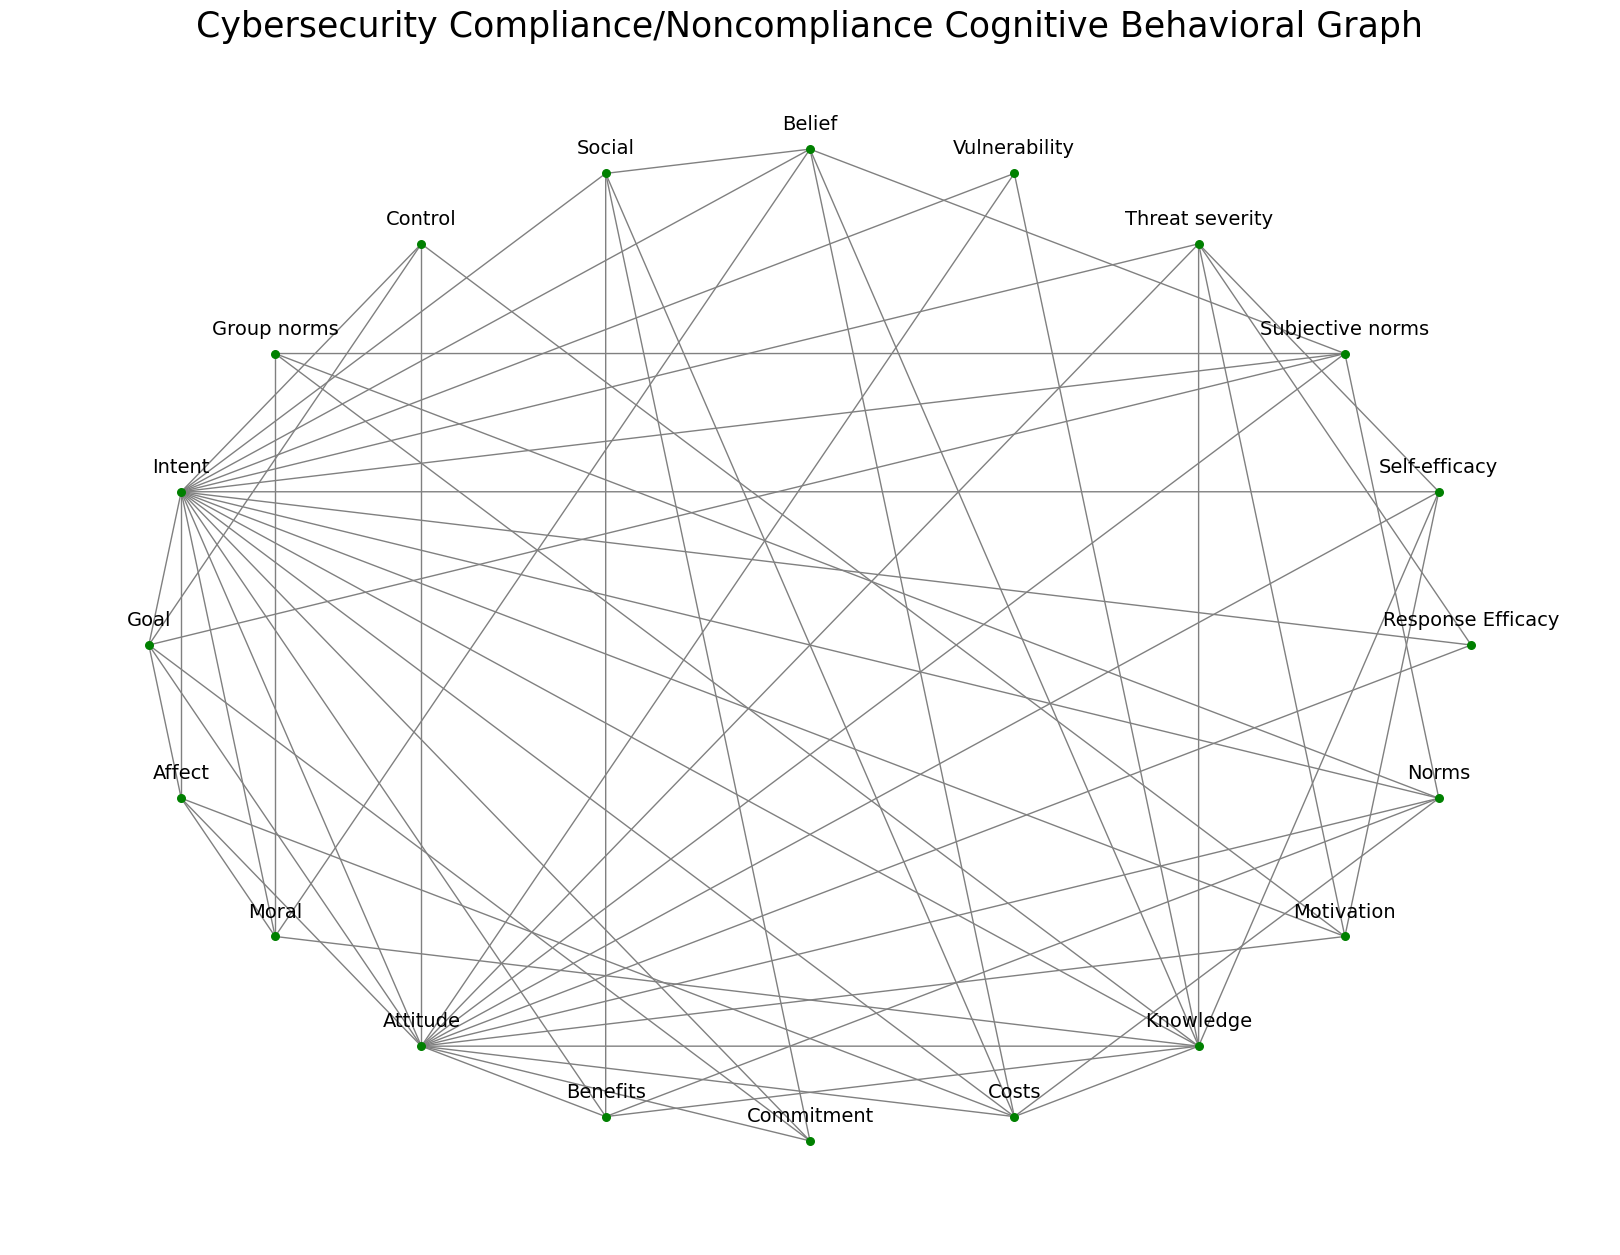

True

In [131]:
#### Dev Only Cell ####
#list(knowledge_graph.edges(data=True))[0:5]
#list(knowledge_graph.nodes(data=True))[0:5]
graph_plot (knowledge_graph,"Cybersecurity Compliance/Noncompliance Cognitive Behavioral Graph")

In [2]:
#### Dev Only Cell ####


. .
.
